In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import keras
from scipy.stats import zscore
pd.set_option("display.max_rows",800)
pd.set_option("display.max_columns",800)
from sklearn.model_selection import train_test_split

In [157]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [158]:
import pandas as pd
class Battery(object):
    def __init__(self,matfile,batname):
        self.matfile=matfile
        self.batname=batname
        self.file=scipy.io.loadmat(self.matfile)
        self.bat=pd.DataFrame(self.file[self.matfile[0:-4]]['cycle'][0][0][0])
    
    def remove_double_type(self):
        types_list=self.file[self.matfile[0:-4]]['cycle'][0][0]['type']
        for i in range(len(types_list[0])-1):
            if types_list[0][i][0]==types_list[0][i+1][0]:
                self.bat.drop(index=i,inplace=True)
            else:
                pass
    
    def Charging_Data(self):
        self.bat_charge=self.bat[self.bat['type']=='charge']
        self.bat_charge.index=range(len(self.bat_charge['type']))
        
        self.bat_discharge=self.bat[self.bat['type']=='discharge']
        self.bat_discharge.index=range(len(self.bat_discharge['type']))
        
        if len(self.bat_charge['type'])!=len(self.bat_discharge['type']):
            self.bat_charge=self.bat_charge.iloc[0:min(len(self.bat_charge['type']),len(self.bat_discharge['type'])),:]
            self.bat_discharge=self.bat_discharge.iloc[0:min(len(self.bat_charge['type']),len(self.bat_discharge['type'])),:]
        
        
        temp_data=pd.DataFrame(columns=range(31))
        for i in range(len(self.bat_charge['type'])):
            x=len(self.bat_charge['data'][i]['Voltage_measured'][0][0][0])
            e=np.mod(x,10)
            V=self.bat_charge['data'][i]['Voltage_measured'][0][0][:,0:x-e].T
            l=len(V)//10
            #V.resize(l,10)
            V.resize(10,l)
            V=V.T
            V=np.mean(V,axis=0)
            
            x=len(self.bat_charge['data'][i]['Current_measured'][0][0][0])
            e=np.mod(x,10)
            C=self.bat_charge['data'][i]['Current_measured'][0][0][:,0:x-e].T
            l=len(C)//10
            #C.resize(l,10)
            C.resize(10,l)
            C=C.T
            C=np.mean(C,axis=0)
            
            x=len(self.bat_charge['data'][i]['Temperature_measured'][0][0][0])
            e=np.mod(x,10)
            T=self.bat_charge['data'][i]['Temperature_measured'][0][0][:,0:x-e].T
            l=len(T)//10
            #T.resize(l,10)
            T.resize(10,l)
            T=T.T
            T=np.mean(T,axis=0)
            
            
            Cap=self.bat_discharge['data'][i]['Capacity'][0][0][0]
            
            VCT=np.concatenate((V,C,T,Cap),axis=0)
            
            temp_data.loc[i,:]=VCT
        temp_data=pd.DataFrame(temp_data.astype('float64'))
        temp_data.insert(loc=0,column='Battery Name',value=self.batname,allow_duplicates=True)
        self.bat_char_profile=temp_data

In [159]:
Bat5=Battery('B0005.mat','B5')
Bat5.remove_double_type()
Bat5.Charging_Data()

C:\Users\Rochan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Rochan\Anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [160]:
Bat6=Battery('B0006.mat','B6')
Bat6.remove_double_type()
Bat6.Charging_Data()

In [161]:
Bat7=Battery('B0007.mat','B7')
Bat7.remove_double_type()
Bat7.Charging_Data()

In [162]:
Bat18=Battery('B0018.mat','B18')
Bat18.remove_double_type()
Bat18.Charging_Data()

In [163]:
Bat5.bat_char_profile=Bat5.bat_char_profile.iloc[1:-1,:]
Bat6.bat_char_profile=Bat6.bat_char_profile.iloc[1:-1,:]
Bat7.bat_char_profile=Bat7.bat_char_profile.iloc[1:-1,:]
Bat18.bat_char_profile=Bat18.bat_char_profile.iloc[1:,:]

In [164]:
b1=Bat5.bat_char_profile.iloc[:,1:11]
b2=Bat6.bat_char_profile.iloc[:,1:11]
b3=Bat7.bat_char_profile.iloc[:,1:11]
b4=Bat18.bat_char_profile.iloc[:,1:11]

scaler_b1=MinMaxScaler()
scaler_b2=MinMaxScaler()
scaler_b3=MinMaxScaler()
scaler_b4=MinMaxScaler()

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

b1=pd.DataFrame(scaler_b1.fit_transform(b1))
b2=pd.DataFrame(scaler_b2.fit_transform(b2))
b3=pd.DataFrame(scaler_b3.fit_transform(b3))
b4=pd.DataFrame(scaler_b4.fit_transform(b4))

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

In [165]:
Dataset=pd.concat((Bat5.bat_char_profile,
                  Bat6.bat_char_profile,
                  Bat7.bat_char_profile,
                  Bat18.bat_char_profile),axis=0)
Dataset.index=range(len(Dataset['Battery Name']))
new_data=pd.concat((b1,b2,b3,b4),axis=0)
new_data.index=Dataset.index

In [166]:
Bat5.bat_char_profile.head()

,Battery Name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
1,B5,3.690312,3.872066,3.938495,3.994200,4.077667,4.195754,4.206338,4.206060,4.206170,4.201204,1.442803,1.510478,1.510550,1.510381,1.510370,1.279228,0.450968,0.175592,0.073273,0.026785,28.396991,27.020713,26.494403,26.637111,27.561202,28.687952,26.753023,25.343756,24.780696,24.680379,1.846327
2,B5,3.698826,3.868629,3.934058,3.988988,4.070164,4.191427,4.206783,4.206015,4.206090,4.200668,1.441762,1.510704,1.510539,1.510670,1.510591,1.320526,0.484489,0.183525,0.076415,0.027668,28.604405,27.222361,26.664024,26.760358,27.633098,28.811019,27.006024,25.521817,24.907895,24.783758,1.835349
3,B5,3.710819,3.869182,3.933773,3.988565,4.070911,4.192607,4.206366,4.205969,4.206107,4.200586,1.441669,1.511001,1.510787,1.510647,1.510886,1.308826,0.476043,0.181684,0.075074,0.027240,28.512727,27.155884,26.600177,26.705674,27.569802,28.729403,26.901313,25.425076,24.809115,24.680906,1.835263
4,B5,3.706908,3.867362,3.932194,3.987331,4.069739,4.192368,4.206682,4.206032,4.206040,4.198874,1.441476,1.510818,1.510598,1.510686,1.510295,1.310393,0.477001,0.179985,0.073310,0.024188,28.517636,27.127751,26.534030,26.601248,27.458292,28.617589,26.798223,25.322336,24.721678,24.615772,1.834646
5,B5,3.705917,3.868404,3.934281,3.991291,4.080314,4.199774,4.206048,4.206243,4.205972,4.196895,1.442677,1.510251,1.510466,1.510421,1.510349,1.216517,0.410503,0.156216,0.061344,0.017570,28.411787,26.991830,26.400031,26.546314,27.477988,28.497705,26.457636,25.171440,24.642001,24.627768,1.835662


In [167]:
b1=Bat5.bat_char_profile.iloc[:,11:21]
b2=Bat6.bat_char_profile.iloc[:,11:21]
b3=Bat7.bat_char_profile.iloc[:,11:21]
b4=Bat18.bat_char_profile.iloc[:,11:21]

scaler_b1=MinMaxScaler()
scaler_b2=MinMaxScaler()
scaler_b3=MinMaxScaler()
scaler_b4=MinMaxScaler()

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

b1=pd.DataFrame(scaler_b1.fit_transform(b1))
b2=pd.DataFrame(scaler_b2.fit_transform(b2))
b3=pd.DataFrame(scaler_b3.fit_transform(b3))
b4=pd.DataFrame(scaler_b4.fit_transform(b4))

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

In [168]:
curr=pd.concat((b1,b2,b3,b4),axis=0)
curr.index=Dataset.index

In [169]:
b1=Bat5.bat_char_profile.iloc[:,21:31]
b2=Bat6.bat_char_profile.iloc[:,21:31]
b3=Bat7.bat_char_profile.iloc[:,21:31]
b4=Bat18.bat_char_profile.iloc[:,21:31]

scaler_b1=MinMaxScaler()
scaler_b2=MinMaxScaler()
scaler_b3=MinMaxScaler()
scaler_b4=MinMaxScaler()

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

b1=pd.DataFrame(scaler_b1.fit_transform(b1))
b2=pd.DataFrame(scaler_b2.fit_transform(b2))
b3=pd.DataFrame(scaler_b3.fit_transform(b3))
b4=pd.DataFrame(scaler_b4.fit_transform(b4))

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

In [170]:
temp=pd.concat((b1,b2,b3,b4),axis=0)
temp.index=Dataset.index

In [171]:
y=Dataset.iloc[:,-1].values.reshape(-1,1)
scaler_y=MinMaxScaler(feature_range=(0,1))
y=scaler_y.fit_transform(y)
y=pd.DataFrame(y)

In [172]:
Multi_Data=pd.concat((Dataset['Battery Name'],new_data,curr,temp,y),axis=1)

In [173]:
Multi_Data.shape

(629, 32)

In [174]:
z=pd.DataFrame(np.abs(zscore(Multi_Data.iloc[:,1:])))
Multi_Data=Multi_Data[(z <4).all(axis=1)]

In [175]:
Multi_Data.shape

(620, 32)

Feedforward Neural Network

In [176]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [185]:
Capacity={'B5':[],'B6':[],'B7':[],'B18':[],}

def Single_Channel_Training(model,battery=['B5','B6','B7','B18']):
    cv=list(combinations(battery,3))
    RMSE=[]
    MAE=[]
    MAPE=[]
    for i in cv:
        i=list(i)
        Test=[x for x in battery if x not in i]
        test_data=Multi_Data[Multi_Data['Battery Name']==Test[0]]
        train_data=Multi_Data[Multi_Data['Battery Name']!=Test[0]]
        X_train=train_data.iloc[:,1:31]
        y_train=train_data.iloc[:,-1].values.reshape(-1,1)
        X_test=test_data.iloc[:,1:31]
        y_test=test_data.iloc[:,-1].values.reshape(-1,1)
        
        model.fit(X_train,y_train,batch_size=50,epochs=500,verbose=0,validation_data=(X_test,y_test))
        
        y_pred=model.predict(X_test)
        y_pred=scaler_y.inverse_transform(y_pred)
        y_test=scaler_y.inverse_transform(y_test)
        
        rmse=np.sqrt(mean_squared_error(y_test,y_pred))
        mae=mean_absolute_error(y_test,y_pred)
        mape=mean_absolute_percentage_error(y_test,y_pred)
        
        print([rmse,mae,mape])
        
        RMSE.append(rmse)
        MAE.append(mae)
        MAPE.append(mape)
        
        Capacity[Test[0]].append(y_pred)
    
    return np.mean(RMSE),np.mean(MAE),np.mean(MAPE)

In [186]:
FNN1=Sequential()
FNN1.add(Dense(units = 10, kernel_initializer = 'normal', input_dim = 30))
FNN1.add(LeakyReLU(alpha=0.3))
FNN1.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))
FNN1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
FNN1.optimizer.learning_rate = 0.001

rmse_1,mae_1,mape_1=Single_Channel_Training(FNN1)
(rmse_1,mae_1,mape_1)

[0.0576266203579998, 0.04469209158554084, 2.752357374457518]
[0.04156226829895371, 0.0334607217018838, 2.08875786489041]
[0.051021778066701974, 0.03999253680601165, 2.533040206081311]
[0.04318425886218427, 0.03162327769109166, 1.9823454223919803]


(0.04834873139645994, 0.03744215694613199, 2.339125216955305)

In [187]:
FNN2=Sequential()
FNN2.add(Dense(units = 40, kernel_initializer = 'normal', input_dim = 30))
FNN2.add(LeakyReLU(alpha=0.1))
FNN2.add(Dropout(0.2))
FNN2.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))
FNN2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
FNN2.optimizer.learning_rate = 0.001

rmse_2,mae_2,mape_2=Single_Channel_Training(FNN2)
(rmse_2,mae_2,mape_2)

[0.052716128023337305, 0.04262409527764843, 2.6793455552132075]
[0.03493866198489427, 0.026486580968891178, 1.6622172496030252]
[0.05795823544169167, 0.046924316163360534, 2.933964004646863]
[0.04515933153643095, 0.03530515023115867, 2.1880404440053924]


(0.04769308924658855, 0.03783503566026471, 2.365891813367122)

Convolutional Neural Network

In [188]:
import keras
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [189]:
def Single_Channel_Training_CNN(model,battery=['B5','B6','B7','B18']):
    cv=list(combinations(battery,3))
    RMSE=[]
    MAE=[]
    MAPE=[]
    for i in cv:
        i=list(i)
        Test=[x for x in battery if x not in i]
        test_data=Multi_Data[Multi_Data['Battery Name']==Test[0]]
        train_data=Multi_Data[Multi_Data['Battery Name']!=Test[0]]
        X_train=train_data.iloc[:,1:31]
        X_train=X_train.values.reshape((len(X_train.index),len(X_train.columns),1,1))
        y_train=train_data.iloc[:,-1].values.reshape(-1,1)
        X_test=test_data.iloc[:,1:31]
        X_test=X_test.values.reshape((len(X_test.index),len(X_test.columns),1,1))
        y_test=test_data.iloc[:,-1].values.reshape(-1,1)
        
        
        model.fit(X_train,y_train,batch_size=50,epochs=500,verbose=0)
        
        y_pred=model.predict(X_test)
        y_pred=scaler_y.inverse_transform(y_pred)
        y_test=scaler_y.inverse_transform(y_test)
        
        rmse=np.sqrt(mean_squared_error(y_test,y_pred))
        mae=mean_absolute_error(y_test,y_pred)
        mape=mean_absolute_percentage_error(y_test,y_pred)
        
        print([rmse,mae,mape])
        
        RMSE.append(rmse)
        MAE.append(mae)
        MAPE.append(mape)
        
        Capacity[Test[0]].append(y_pred)
    
    return np.mean(RMSE),np.mean(MAE),np.mean(MAPE)

In [190]:
CNN1=Sequential()
CNN1.add(Conv2D(filters=10,kernel_size=(1,2),kernel_initializer='normal',input_shape=(30,1,1),padding='same'))
CNN1.add(LeakyReLU(alpha=0.1))
CNN1.add(Conv2D(filters=5,kernel_size=(1,2),kernel_initializer='normal',padding='same'))
CNN1.add(LeakyReLU(alpha=0.1))
CNN1.add(Flatten())
CNN1.add(Dense(units=1,activation='linear'))
CNN1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
CNN1.summary()
rmse_3,mae_3,mape_3=Single_Channel_Training_CNN(CNN1)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 1, 10)         30        
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 30, 1, 10)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 1, 5)          105       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 30, 1, 5)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 151       
Total params: 286
Trainable params: 286
Non-trainable params: 0
_______________________________________________________

In [191]:
CNN2=Sequential()
CNN2.add(Conv2D(filters=30,kernel_size=(1,2),kernel_initializer='normal',input_shape=(30,1,1),padding='same'))
CNN2.add(LeakyReLU(alpha=0.1))
CNN2.add(Dropout(0.2))
CNN2.add(Conv2D(filters=15,kernel_size=(1,2),kernel_initializer='normal',padding='same'))
CNN2.add(LeakyReLU(alpha=0.1))
CNN2.add(Dropout(0.2))
CNN2.add(Flatten())
CNN2.add(Dense(units=1,activation='linear'))
CNN2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
CNN2.summary()
rmse_4,mae_4,mape_4=Single_Channel_Training_CNN(CNN2)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 30, 1, 30)         90        
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 30, 1, 30)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 30, 1, 30)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 1, 15)         915       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 30, 1, 15)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 30, 1, 15)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 450)             

In [192]:
import keras
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LSTM

In [193]:
battery_5_lstm_X=[]
battery_6_lstm_X=[]
battery_7_lstm_X=[]
battery_18_lstm_X=[]

battery_5_lstm_y=[]
battery_6_lstm_y=[]
battery_7_lstm_y=[]
battery_18_lstm_y=[]


b1=Multi_Data[Multi_Data['Battery Name']=='B5'].iloc[:,1:32].values
b2=Multi_Data[Multi_Data['Battery Name']=='B6'].iloc[:,1:32].values
b3=Multi_Data[Multi_Data['Battery Name']=='B7'].iloc[:,1:32].values
b4=Multi_Data[Multi_Data['Battery Name']=='B18'].iloc[:,1:32].values

for i in range(5, b1.shape[0]):
    battery_5_lstm_X.append(b1[i-5:i,0:31])
    battery_5_lstm_y.append(b1[i,-1])
battery_5_lstm_X, battery_5_lstm_y = np.array(battery_5_lstm_X), np.array(battery_5_lstm_y)

for i in range(5, b2.shape[0]):
    battery_6_lstm_X.append(b2[i-5:i,0:31])
    battery_6_lstm_y.append(b2[i,-1])
battery_6_lstm_X, battery_6_lstm_y = np.array(battery_6_lstm_X), np.array(battery_6_lstm_y)

for i in range(5, b3.shape[0]):
    battery_7_lstm_X.append(b3[i-5:i,0:31])
    battery_7_lstm_y.append(b3[i, -1])
battery_7_lstm_X, battery_7_lstm_y = np.array(battery_7_lstm_X), np.array(battery_7_lstm_y)

for i in range(5, b4.shape[0]):
    battery_18_lstm_X.append(b4[i-5:i,0:31])
    battery_18_lstm_y.append(b4[i, -1])
battery_18_lstm_X, battery_18_lstm_y = np.array(battery_18_lstm_X), np.array(battery_18_lstm_y)

In [194]:
LSTM1=Sequential()
LSTM1.add(LSTM(units=52,return_sequences=False,input_shape=((5,31))))
LSTM1.add(LeakyReLU(alpha=0.1))
LSTM1.add(Dropout(0.2))
LSTM1.add(Dense(units=1,activation='linear'))
LSTM1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
LSTM1.optimizer.learning_rate = 0.001
LSTM1.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 52)                17472     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 52)                0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 52)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 53        
Total params: 17,525
Trainable params: 17,525
Non-trainable params: 0
_________________________________________________________________


In [213]:
Training_X=np.concatenate((battery_5_lstm_X,battery_6_lstm_X,battery_7_lstm_X))
Training_y=np.concatenate((battery_5_lstm_y,battery_6_lstm_y,battery_7_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_18_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_18_lstm_y.reshape(-1,1))
rmse18=np.sqrt(mean_squared_error(y_test,y_pred))
mae18=mean_absolute_error(y_test,y_pred)
mape18=mean_absolute_percentage_error(y_test,y_pred)

lstm18=y_pred

In [214]:
(rmse18,mae18,mape18)

(0.03005219733965423, 0.023620263112513414, 1.542366678264709)

In [215]:
Training_X=np.concatenate((battery_5_lstm_X,battery_6_lstm_X,battery_18_lstm_X))
Training_y=np.concatenate((battery_5_lstm_y,battery_6_lstm_y,battery_18_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_7_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_7_lstm_y.reshape(-1,1))
rmse7=np.sqrt(mean_squared_error(y_test,y_pred))
mae7=mean_absolute_error(y_test,y_pred)
mape7=mean_absolute_percentage_error(y_test,y_pred)

lstm7=y_pred


(rmse7,mae7,mape7)

(0.015542053415126423, 0.011109302580810228, 0.6791309240197336)

In [216]:
Training_X=np.concatenate((battery_5_lstm_X,battery_18_lstm_X,battery_7_lstm_X))
Training_y=np.concatenate((battery_5_lstm_y,battery_18_lstm_y,battery_7_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_6_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_6_lstm_y.reshape(-1,1))
rmse6=np.sqrt(mean_squared_error(y_test,y_pred))
mae6=mean_absolute_error(y_test,y_pred)
mape6=mean_absolute_percentage_error(y_test,y_pred)

lstm6=y_pred
(rmse6,mae6,mape6)

(0.022324463057235178, 0.015207323095637056, 1.0042032895443964)

In [217]:
Training_X=np.concatenate((battery_18_lstm_X,battery_6_lstm_X,battery_7_lstm_X))
Training_y=np.concatenate((battery_18_lstm_y,battery_6_lstm_y,battery_7_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_5_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_5_lstm_y.reshape(-1,1))
rmse5=np.sqrt(mean_squared_error(y_test,y_pred))
mae5=mean_absolute_error(y_test,y_pred)
mape5=mean_absolute_percentage_error(y_test,y_pred)

lstm5=y_pred

(rmse5,mae5,mape5)

(0.011947153842362166, 0.00954706030717884, 0.6015523440280575)

In [218]:
(rmse18+rmse7+rmse6+rmse5)/4

0.0199664669135945

In [219]:
#file=open('Predicted Capacity','rb')

In [220]:
#import pickle
#Capacity=pickle.load(file)

In [221]:
#file.close()

In [222]:
#Capacity['B5'].append(lstm5)
#Capacity['B6'].append(lstm6)
#Capacity['B7'].append(lstm7)
#Capacity['B18'].append(lstm18)

In [223]:
rmse_5=[]
rmse_5.append(rmse5)
rmse_5.append(rmse6)
rmse_5.append(rmse7)
rmse_5.append(rmse18)
rmse_5=np.mean(rmse_5)

In [224]:
mae_5=[]
mae_5.append(mae5)
mae_5.append(mae6)
mae_5.append(mae7)
mae_5.append(mae18)
mae_5=np.mean(mae_5)

In [225]:
mape_5=[]
mape_5.append(mape5)
mape_5.append(mape6)
mape_5.append(mape7)
mape_5.append(mape18)
mape_5=np.mean(mape_5)

In [226]:
Multi_Channel_Results=pd.DataFrame(index=['MC-FNN1','MC-FNN2','MC-CNN1','MC-CNN2','MC_LSTM'],columns=['RMSE','MAE','MAPE(%)'])

In [227]:
Multi_Channel_Results.iloc[0,:]=[rmse_1,mae_1,mape_1]
Multi_Channel_Results.iloc[1,:]=[rmse_2,mae_2,mape_2]
Multi_Channel_Results.iloc[2,:]=[rmse_3,mae_3,mape_3]
Multi_Channel_Results.iloc[3,:]=[rmse_4,mae_4,mape_4]
Multi_Channel_Results.iloc[4,:]=[rmse_5,mae_5,mape_5]

In [228]:
Multi_Channel_Results

,RMSE,MAE,MAPE(%)
MC-FNN1,0.0483487,0.0374422,2.33913
MC-FNN2,0.0476931,0.037835,2.36589
MC-CNN1,0.0401936,0.0311042,1.95928
MC-CNN2,0.0565017,0.0478504,3.06942
MC_LSTM,0.0199665,0.014871,0.956813


In [229]:
Capacity['B5'].append(lstm5)
Capacity['B6'].append(lstm6)
Capacity['B7'].append(lstm7)
Capacity['B18'].append(lstm18)

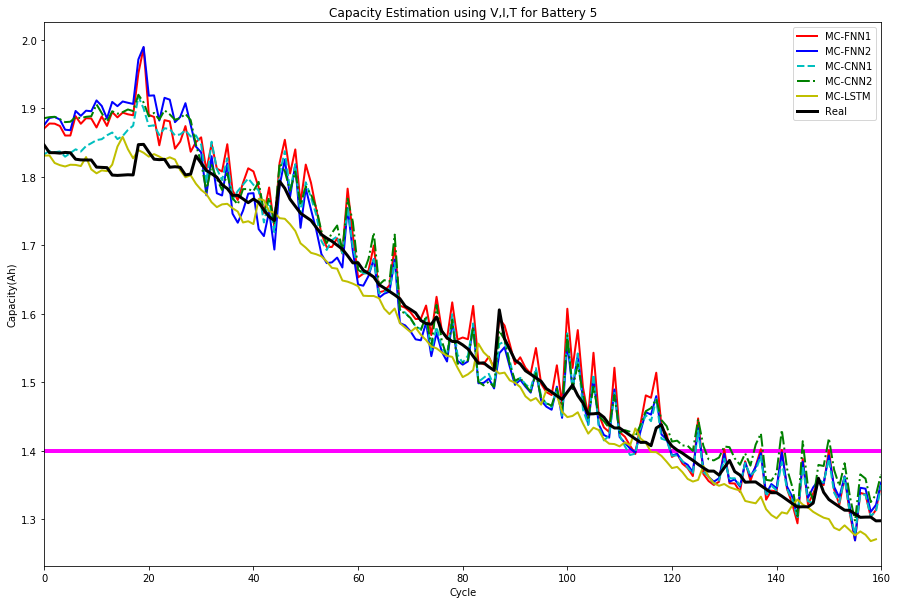

In [234]:
y_test=Multi_Data[Multi_Data['Battery Name']=='B5'].iloc[:,-1].values.reshape(-1,1)
y_test=scaler_y.inverse_transform(y_test)
plt.figure(figsize=(15,10))
plt.plot(Capacity['B5'][0],'r-',label='MC-FNN1',lw=2)
plt.plot(Capacity['B5'][1],'b-',label='MC-FNN2',lw=2)
plt.plot(Capacity['B5'][2],'c--',label='MC-CNN1',lw=2)
plt.plot(Capacity['B5'][3],'g-.',label='MC-CNN2',lw=2)
plt.plot(Capacity['B5'][4],'y-',label='MC-LSTM',lw=2)
plt.plot(y_test,color='black',label='Real',lw=3)
plt.hlines(y=1.4,xmin=0,xmax=len(y_test),color='magenta',lw=4)
plt.xlim(0,len(y_test)-5)
plt.xlabel('Cycle')
plt.ylabel('Capacity(Ah)')
plt.title('Capacity Estimation using V,I,T for Battery 5')
plt.legend()
plt.savefig('Battery_5_MC.jpeg')

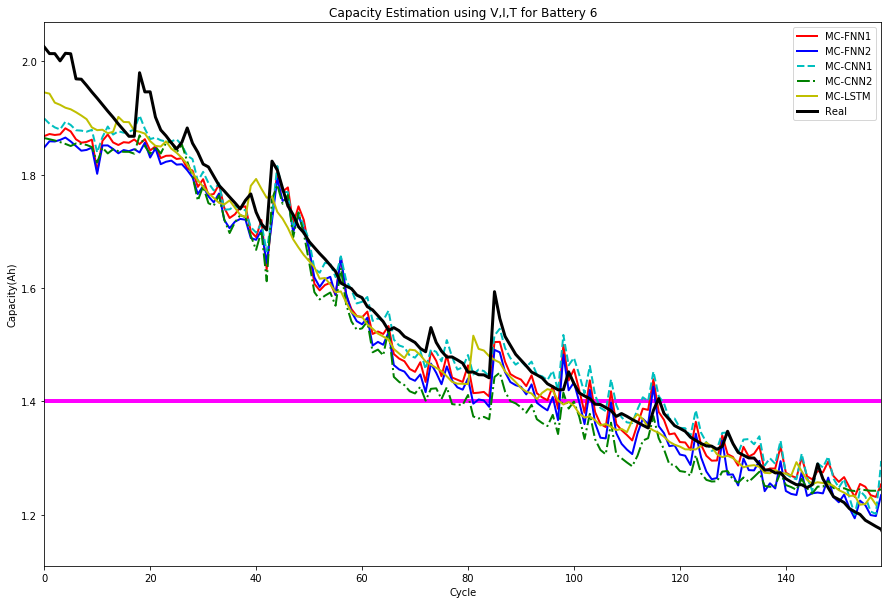

In [235]:
y_test=Multi_Data[Multi_Data['Battery Name']=='B6'].iloc[:,-1].values.reshape(-1,1)
y_test=scaler_y.inverse_transform(y_test)
plt.figure(figsize=(15,10))
plt.plot(Capacity['B6'][0],'r-',label='MC-FNN1',lw=2)
plt.plot(Capacity['B6'][1],'b-',label='MC-FNN2',lw=2)
plt.plot(Capacity['B6'][2],'c--',label='MC-CNN1',lw=2)
plt.plot(Capacity['B6'][3],'g-.',label='MC-CNN2',lw=2)
plt.plot(Capacity['B6'][4],'y-',label='MC-LSTM',lw=2)
plt.plot(y_test,color='black',label='Real',lw=3)
plt.hlines(y=1.4,xmin=0,xmax=len(y_test),color='magenta',lw=4)
plt.xlim(0,len(y_test)-5)
plt.xlabel('Cycle')
plt.ylabel('Capacity(Ah)')
plt.title('Capacity Estimation using V,I,T for Battery 6')
plt.legend()
plt.savefig('Battery_6_MC.jpeg')

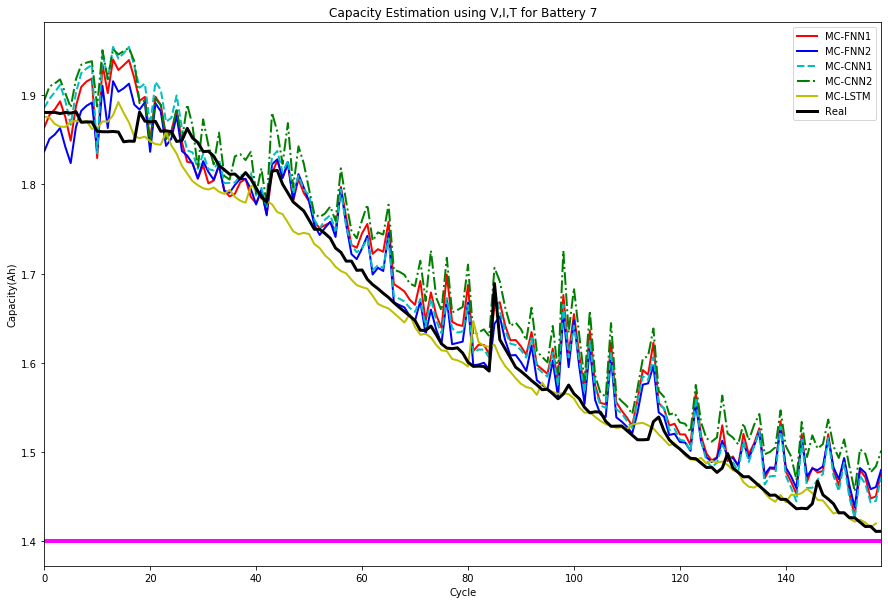

In [236]:
y_test=Multi_Data[Multi_Data['Battery Name']=='B7'].iloc[:,-1].values.reshape(-1,1)
y_test=scaler_y.inverse_transform(y_test)
plt.figure(figsize=(15,10))
plt.plot(Capacity['B7'][0],'r-',label='MC-FNN1',lw=2)
plt.plot(Capacity['B7'][1],'b-',label='MC-FNN2',lw=2)
plt.plot(Capacity['B7'][2],'c--',label='MC-CNN1',lw=2)
plt.plot(Capacity['B7'][3],'g-.',label='MC-CNN2',lw=2)
plt.plot(Capacity['B7'][4],'y-',label='MC-LSTM',lw=2)
plt.plot(y_test,color='black',label='Real',lw=3)
plt.hlines(y=1.4,xmin=0,xmax=len(y_test),color='magenta',lw=4)
plt.xlim(0,len(y_test)-5)
plt.xlabel('Cycle')
plt.ylabel('Capacity(Ah)')
plt.title('Capacity Estimation using V,I,T for Battery 7')
plt.legend()
plt.savefig('Battery_7_MC.jpeg')

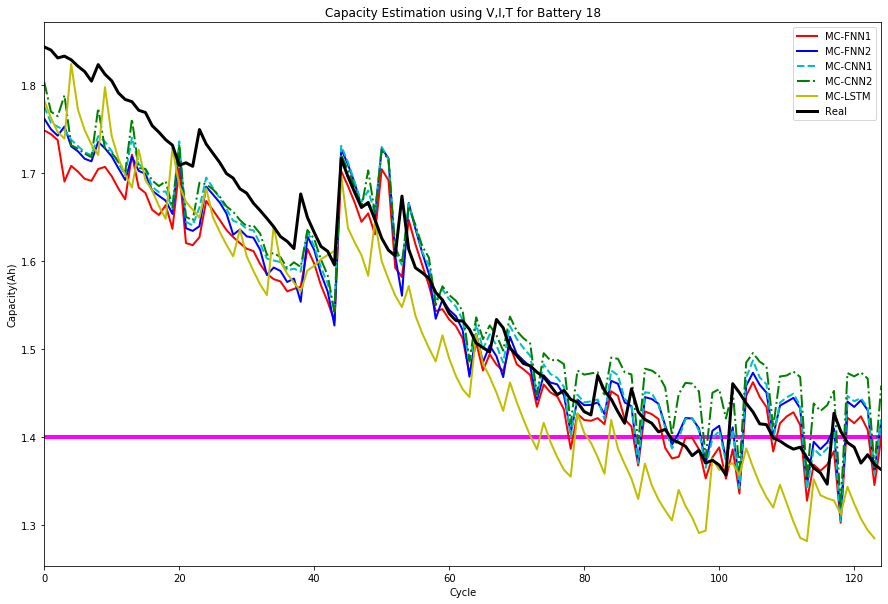

In [237]:
y_test=Multi_Data[Multi_Data['Battery Name']=='B18'].iloc[:,-1].values.reshape(-1,1)
y_test=scaler_y.inverse_transform(y_test)
plt.figure(figsize=(15,10))
plt.plot(Capacity['B18'][0],'r-',label='MC-FNN1',lw=2)
plt.plot(Capacity['B18'][1],'b-',label='MC-FNN2',lw=2)
plt.plot(Capacity['B18'][2],'c--',label='MC-CNN1',lw=2)
plt.plot(Capacity['B18'][3],'g-.',label='MC-CNN2',lw=2)
plt.plot(Capacity['B18'][4],'y-',label='MC-LSTM',lw=2)
plt.plot(y_test,color='black',label='Real',lw=3)
plt.hlines(y=1.4,xmin=0,xmax=len(y_test),color='magenta',lw=4)
plt.xlim(0,len(y_test)-5)
plt.xlabel('Cycle')
plt.ylabel('Capacity(Ah)')
plt.title('Capacity Estimation using V,I,T for Battery 18')
plt.legend()
plt.savefig('Battery_18_MC.jpeg')

In [ ]:
import pickle
file=open('Predicted_Cap_MC','wb')
pickle.dump(Capacity,file)
file.close()

In [238]:
Multi_Channel_Results

,RMSE,MAE,MAPE(%)
MC-FNN1,0.0483487,0.0374422,2.33913
MC-FNN2,0.0476931,0.037835,2.36589
MC-CNN1,0.0401936,0.0311042,1.95928
MC-CNN2,0.0565017,0.0478504,3.06942
MC_LSTM,0.0199665,0.014871,0.956813


In [240]:
Multi_Channel_Results.to_csv('Multi_Channel_Results.csv',float_format='%.3f',index=False)